## Working with Xarray

[Xarray](http://xarray.pydata.org/) is an evolution of rasterio and is inspired by libraries like pandas to work with raster datasets. It is particularly suited for working with multi-dimensional time-series raster datasets. It also integrates tightly with [dask](https://dask.org/) that allows one to scale raster data processing using parallel computing.

[rioxarray](https://corteva.github.io/rioxarray/stable/index.html) is an extension of xarray that makes it easy to work with geospatial rasters. You can install the `rioxarray` package from the `conda-forge` channel. 

This notebook shows how we can replicate the analysis from the [Working with RasterIO](#working-with-rasterio) exercise and also covers raster data visualization using `matplotlib`. 

### XArray and rioxarray Basics

We start by reading a single SRTM tile containing elevation values.

In [19]:
import os
import numpy as np
data_pkg_path = 'data'
srtm_dir = 'srtm'
filename = 'N28E087.hgt'
path = os.path.join(data_pkg_path, srtm_dir, filename)

By convention, `rioxarray` is imported as `rxr`

In [2]:
import rioxarray as rxr

The `open_rasterio()` method is able to read any data source supported by `rasterio` library.

In [3]:
rds = rxr.open_rasterio(path)

The result is a `xarray.DataArray` object.

In [4]:
type(rds)

xarray.core.dataarray.DataArray

You can access the pixel values using the `values` property which returns the array’s data as a numpy array.

In [5]:
rds.values

array([[[5217, 5211, 5208, ..., 5097, 5098, 5089],
        [5206, 5201, 5200, ..., 5080, 5075, 5069],
        [5199, 5194, 5191, ..., 5063, 5055, 5048],
        ...,
        [5347, 5345, 5343, ..., 5747, 5750, 5757],
        [5338, 5338, 5336, ..., 5737, 5740, 5747],
        [5332, 5331, 5332, ..., 5734, 5736, 5744]]], dtype=int16)

A `xarray.DataArray` object also contains 1 or more `coordinates`. Each coordinate is a 1-dimensional array representing values along one of the data axes. In case of the 1-band SRTM elevation data, we have 3 coordinates - `x`, `y` and `band`.

In [6]:
rds.coords

Coordinates:
  * band         (band) int64 1
  * x            (x) float64 87.0 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29.0 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 0

A key feature of `xarray` is the ability to access slices of the dataset using [index lookup](http://xarray.pydata.org/en/stable/user-guide/indexing.html) methods. For example, we can slice the main dataset and get the data for Band1 using the `sel()` method.

In [7]:
band1 = rds.sel(band=1)

The raster metadata is stored in the [`rio`](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors) accessor. This is enabled by the `rioxarray` library which provides geospatial functions on top of `xarray`. 

In [8]:
print('CRS:', rds.rio.crs)
print('Resolution:', rds.rio.resolution())
print('Bounds:', rds.rio.bounds())
print('Width:', rds.rio.width)
print('Height:', rds.rio.height)

CRS: EPSG:4326
Resolution: (0.0002777777777777778, -0.0002777777777777778)
Bounds: (86.99986111111112, 27.999861111111112, 88.00013888888888, 29.000138888888888)
Width: 3601
Height: 3601


### Merging Rasters

Now that you understand the basic data structure of *xarray* and the &rio* extension, let's use it to process some data. We will take 4 individual SRTM tiles and merge them to a single GeoTiff. You will note that `rioxarray` handles the CRS and transform much better - taking care of internal details and providing a simple API.

> Remember to always import `rioxarray` even if you are using sub-modules. Importing `rioxarray` activates the `rio` accessor which is required for all operations.

In [9]:
import rioxarray as rxr
from rioxarray.merge import merge_arrays

Define input and output paths.

In [10]:
srtm_path = os.path.join(data_pkg_path, 'srtm')
all_files = os.listdir(srtm_path)
output_filename = 'merged.tif'
output_dir = 'output'
output_path = os.path.join(output_dir, output_filename)

Open each source file using `open_rasterio()` method and store the resulting datasets in a list.

In [11]:
datasets = []
for file in all_files:
    path = os.path.join(srtm_path, file)
    datasets.append(rxr.open_rasterio(path))

Use the `merge_arrays()` method from the `rioxarray.merge` module to merge the rasters.

In [12]:
merged = merge_arrays(datasets)

Finally, save the merged array to disk as a GeoTiff file.

In [13]:
merged.rio.to_raster(output_path)

### Visualizing Rasters using Matplotlib

`xarray` plotting functionality is built on top of the the popular `matplotlib` library. 

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

You cna visualize any `DataArray` object by calling `plot()` method. Here we create a row of 4 plots and render each of the source SRTM rasters. We can use the `cmap` option to specify a color ramp. Here we are using the built-in *Greys* ramp. Appending **_r** gives us the inverted ramp with blacks representing lower elevation values.

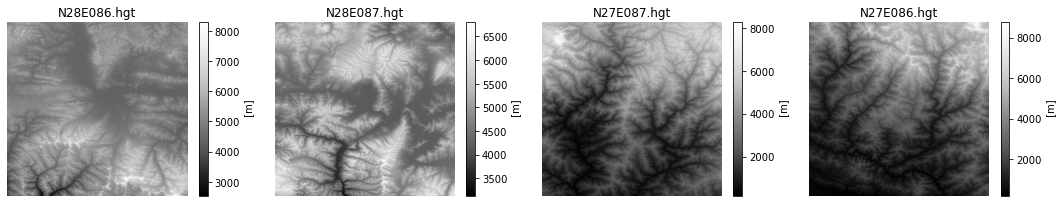

In [15]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,3)
plt.tight_layout()
for index, dataset in enumerate(datasets):
    ax = axes[index]
    dataset.plot(ax=ax, cmap='Greys_r')
    ax.axis('off')
    filename = all_files[index]
    ax.set_title(filename)

Similarly, we can visualize the merged raster.

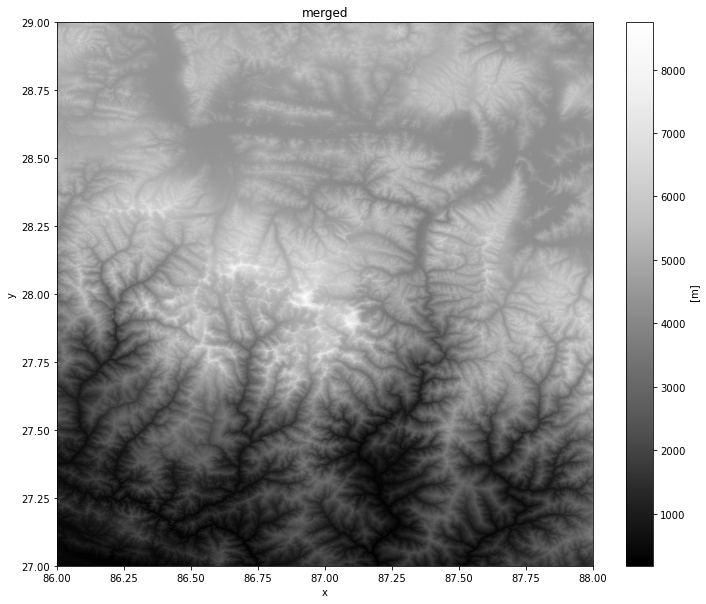

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
merged.plot(ax=ax, cmap='Greys_r')
ax.set_title('merged')
plt.show()

In [17]:
merged

<xarray.DataArray (band: 1, y: 7201, x: 7201)>
array([[[4916, 4926, 4931, ..., 5097, 5098, 5089],
        [4919, 4932, 4928, ..., 5080, 5075, 5069],
        [4919, 4928, 4935, ..., 5063, 5055, 5048],
        ...,
        [ 368,  368,  366, ..., 1905, 1919, 1937],
        [ 364,  364,  362, ..., 1913, 1930, 1944],
        [ 360,  359,  357, ..., 1918, 1930, 1942]]], dtype=int16)
Coordinates:
  * x            (x) float64 86.0 86.0 86.0 86.0 86.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29.0 29.0 29.0 29.0 29.0 ... 27.0 27.0 27.0 27.0
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    _FillValue:    -32768
    scale_factor:  1.0
    add_offset:    0.0
    units:         m

In [69]:
bands, rows, cols = np.where(merged == np.max(merged))
band = bands[0]
row = rows[0]
col = cols[0]
print(band, row, col)

0 3640 3332


In [70]:
result = merged.isel(band=band, x=col, y=row)
lat = result.y.values
lon = result.x.values
elevation = int(result)
print(lat, lon, elevation)

27.988888888888887 86.92555555555556 8748


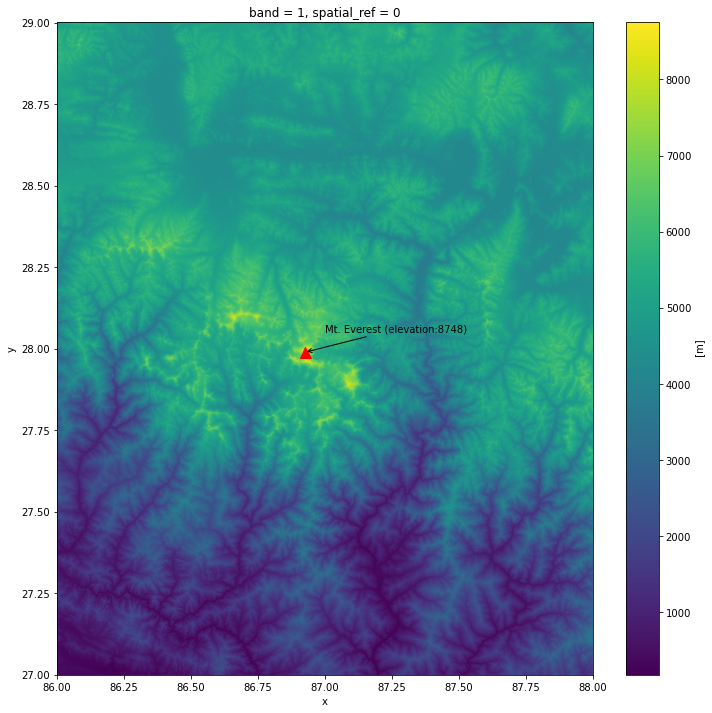

In [71]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 12)
merged.plot(ax=ax, cmap='viridis')
ax.plot(lon, lat, '^r', markersize=11)
ax.annotate('Mt. Everest (elevation:{}m)'.format(elevation),
            xy=(lon, lat), xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black')
            )

output_folder = 'output'
output_path = os.path.join(output_folder, 'mt_everest.png')
plt.savefig(output_path, dpi=300)

plt.show()